In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams["font.family"] = "Arial"
plt.rcParams['legend.title_fontsize'] = 7
plt.rcParams["text.usetex"] = True

SAVE = True

base_dir = os.path.abspath("..")
results_dir = os.path.join(base_dir, "..", "results")
figures_dir = os.path.join(base_dir, "..", "figures")

gen_refs = pd.read_csv(os.path.join(results_dir, f"merged_gen_refs_vanilla_gpt-4_unique.csv"))
intro_refs = pd.read_csv(os.path.join(results_dir, f"merged_intro_refs_vanilla_gpt-4_unique.csv"))

# Only use references that correspond to existing generated
mask = gen_refs["Exists"] == 1.0
intro_refs = intro_refs[mask]
gen_refs = gen_refs[mask]

/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_5530/3196756019.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intro["Type"] = "Ground truth references"
/var/folders/kq/bwvwl1hd4g12lmk871x7q_br0000gn/T/ipykernel_5530/3196756019.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing["Type"] = "Existing generated references"


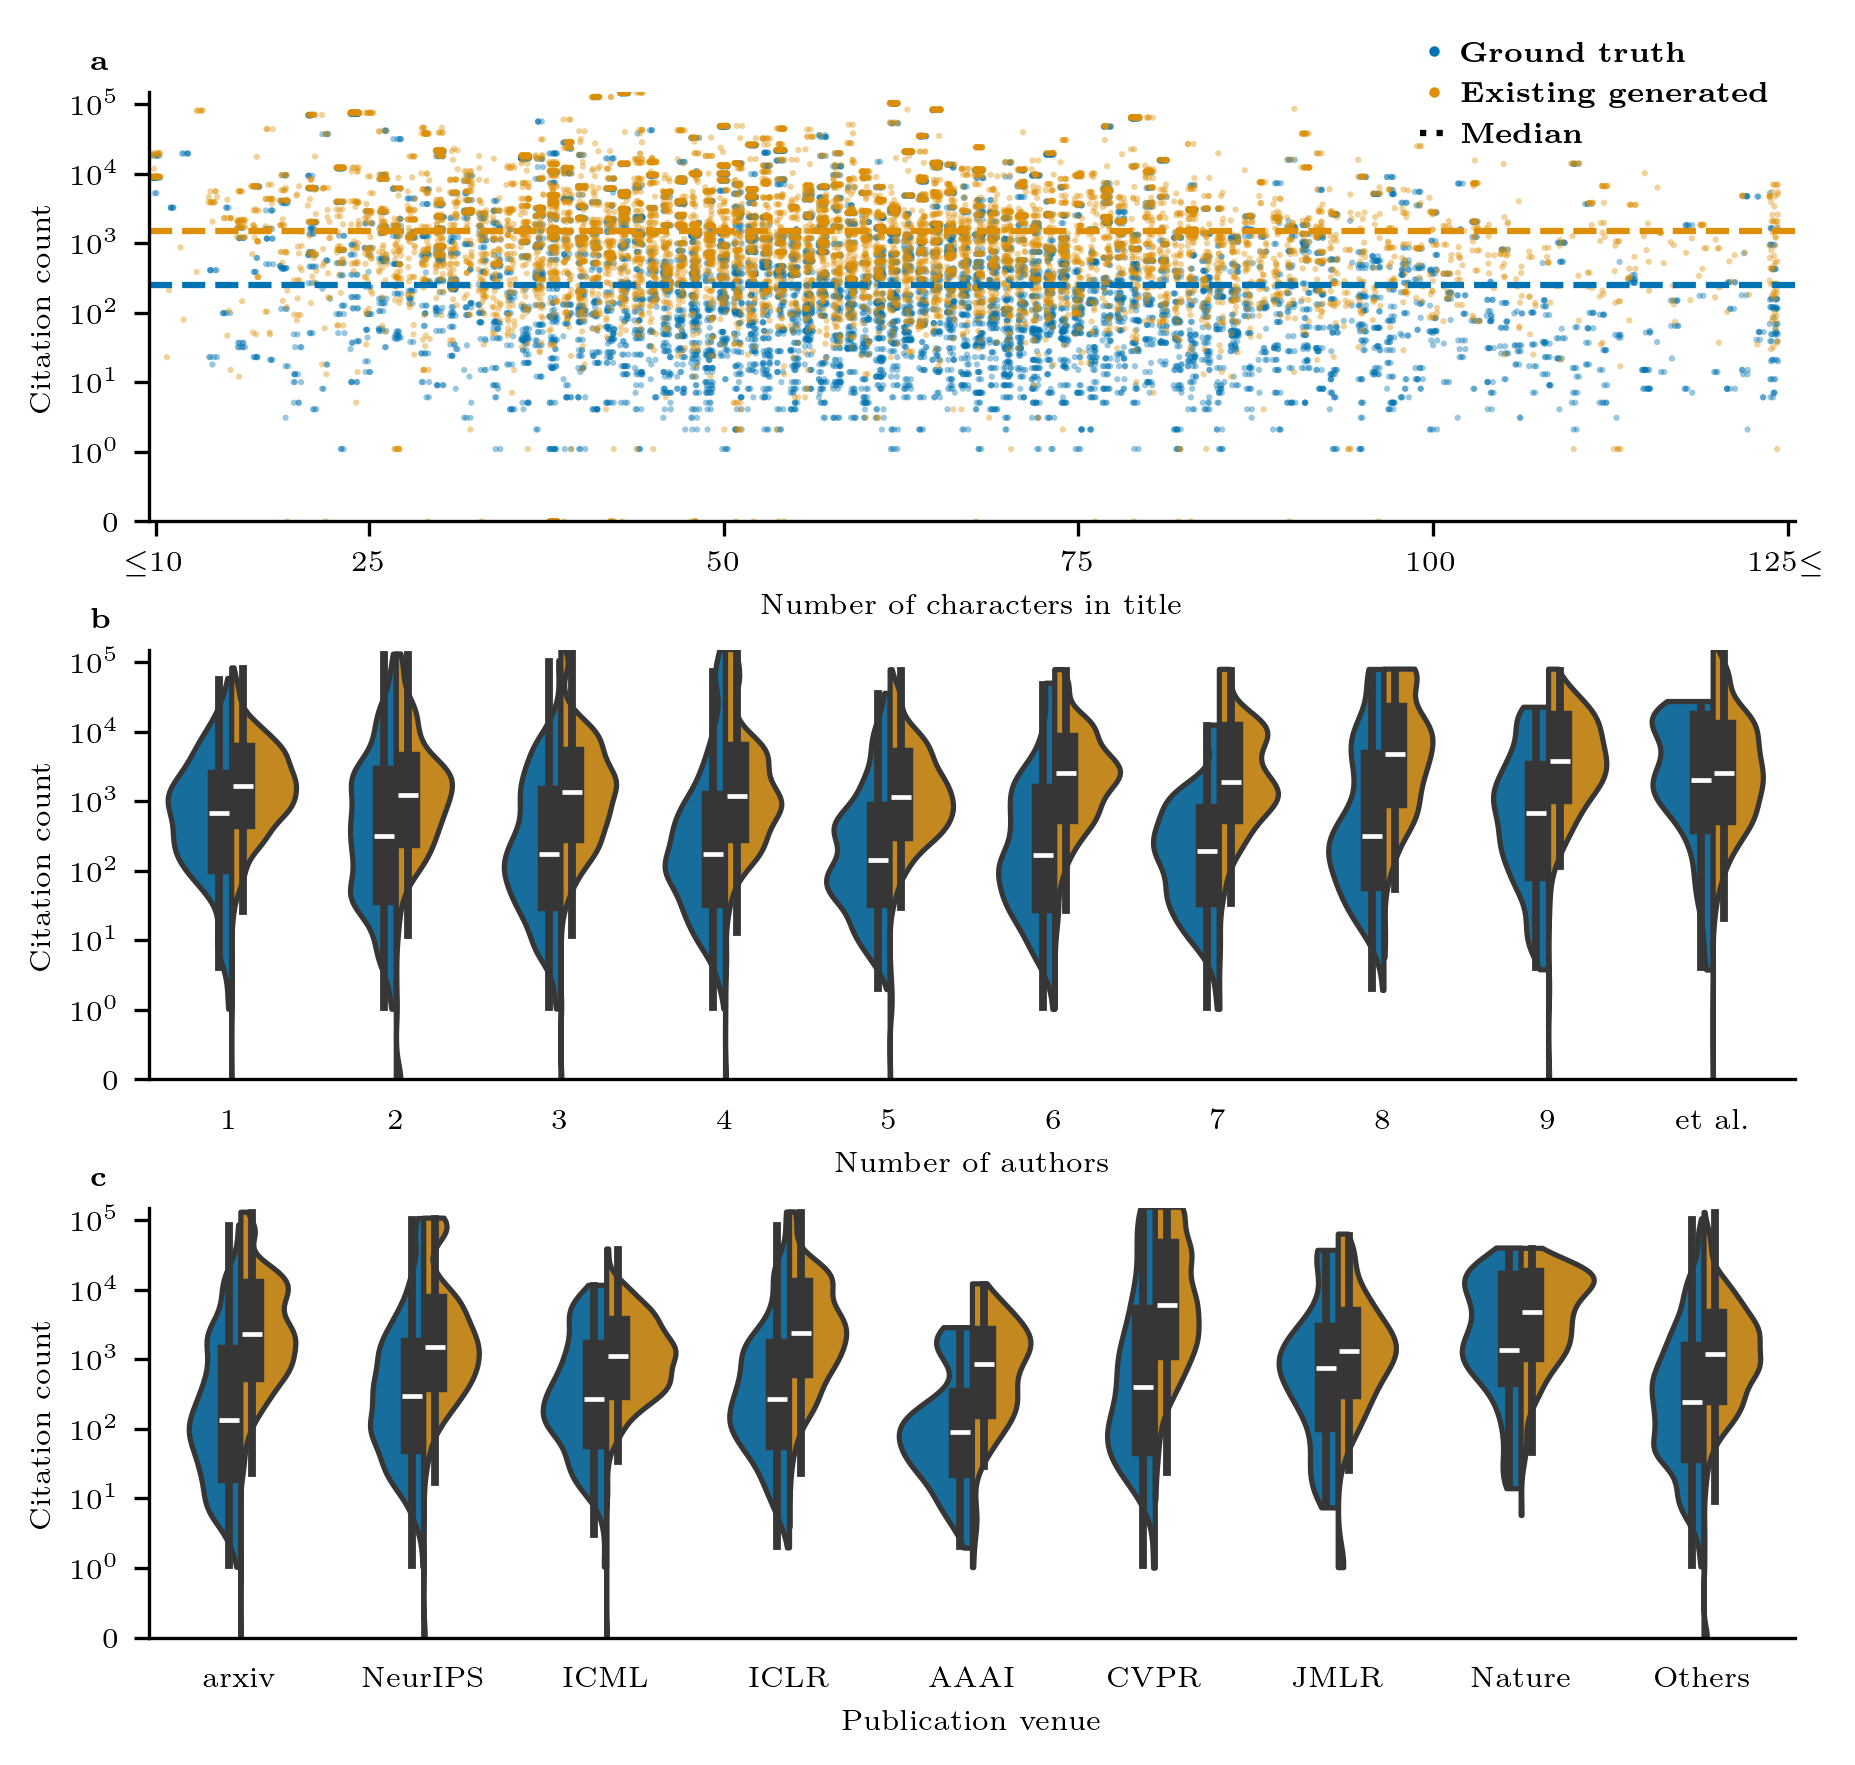

In [2]:
# Main Figure 4

# Publications and years
Figure1, ax1 = plt.subplot_mosaic(
    [["C"], ["B"], ["A"]],
    figsize=(7.08,6.69),
    dpi=300,
    gridspec_kw={'wspace': 0, 'hspace': 0.3}
)

VENUES = ['arxiv', 'NeurIPS', 'ICML', 'ICLR', 'AAAI', 'CVPR', 'JMLR', 'Nature']
intro_refs.loc[~intro_refs["Publication Venue_processed"].isin(VENUES), "Publication Venue_processed"] = "Others"
gen_refs.loc[~gen_refs["Publication Venue_processed"].isin(VENUES), "Publication Venue_processed"] = "Others"

intro = intro_refs[["Publication Venue_processed", "Number of Authors", "Title Length", "Citation Count_sch"]]
intro["Type"] = "Ground truth references"

existing = gen_refs[["Publication Venue_processed", "Number of Authors", "Title Length", "Citation Count_sch"]]
existing["Type"] = "Existing generated references"

df = pd.concat([intro, existing], ignore_index=True)
df["Citation Count_sch"] += 0.1
df.dropna(subset=["Publication Venue_processed", "Number of Authors"], axis=0, inplace=True)

def safe_cast(val):
    try:
        return float(val)
    except (ValueError, TypeError):
        return 0
    
df["Number of Authors"] = df["Number of Authors"].apply(lambda x: 9.0 if safe_cast(x) >= 9 else x)

df.loc[df["Title Length"] < 10, "Title Length"] = 10
df.loc[df["Title Length"] > 125, "Title Length"] = 125

# plot 1
sns.violinplot(
    data=df,
    x="Publication Venue_processed",
    y="Citation Count_sch",
    hue="Type",
    cut=0.1,
    log_scale=True,
    palette="colorblind",
    split=True,
    inner="box",
    legend=False,
    order=VENUES + ["Others"],
    ax=ax1["A"],
)

ax1["A"].tick_params(bottom=False)

ax1["A"].set_ylim(0.1, 150000)
ax1["A"].set_xlabel("Publication venue", fontsize=7)
ax1["A"].set_ylabel("Citation count", fontsize=7)
ax1["A"].set_yticks(ticks=[0.1, 1, 10, 100, 1000, 10000, 100000], 
              labels=["0", r"$10^0$", r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"], fontsize=7)
ax1["A"].set_xticks(ticks=[0,1,2,3,4,5,6,7,8],
                    labels=VENUES + ["Others"],
                    fontsize=7)

sns.despine(ax=ax1["A"])

# plot 2
sns.violinplot(
    data=df,
    x="Number of Authors",
    y="Citation Count_sch",
    hue="Type",
    cut=0.1,
    log_scale=True,
    palette="colorblind",
    split=True,
    inner="box",
    legend=False,
    order=[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,"et al."],
    ax=ax1["B"],
)

ax1["B"].tick_params(bottom=False)

ax1["B"].set_ylim(0.1, 150000)
ax1["B"].set_xlabel("Number of authors", fontsize=7)
ax1["B"].set_ylabel("Citation count", fontsize=7)
ax1["B"].set_yticks(ticks=[0.1, 1, 10, 100, 1000, 10000, 100000], 
              labels=["0", r"$10^0$", r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"], fontsize=7)
ax1["B"].set_xticks(ticks=[0,1,2,3,4,5,6,7,8,9],
                    labels=["1","2","3","4","5","6","7","8","9","et al."],
                    fontsize=7)

sns.despine(ax=ax1["B"])

# plot 3
sns.stripplot(
    data=df,
    x="Title Length",
    y="Citation Count_sch",
    hue="Type",
    palette="colorblind",
    size=1.5,
    alpha=0.4,
    jitter=0.3,
    log_scale=True,
    ax=ax1["C"],
    legend=False,
    zorder=0,
)

ax1["C"].axhline(y=df.loc[df["Type"] == "Ground truth references", "Citation Count_sch"].median(), color="#0173b2", linestyle='--')
ax1["C"].axhline(y=df.loc[df["Type"] == "Existing generated references", "Citation Count_sch"].median(), color='#de8f05', linestyle='--')

ax1["C"].set(xlim=(-0.5,115.5))
ax1["C"].set_ylim(0.1, 150000)
ax1["C"].set_xlabel("Number of characters in title", fontsize=7)
ax1["C"].set_ylabel("Citation count", fontsize=7)
ax1["C"].set_yticks(ticks=[0.1, 1, 10, 100, 1000, 10000, 100000], 
              labels=["0", r"$10^0$", r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"], fontsize=7)
ax1["C"].set_xticks(ticks=[0,15,40,65,90,115], labels=[r"$\small \leq$10","25","50","75","100",r"125$ \small \leq$"], fontsize=7)

sns.despine(ax=ax1["C"])

# legend
ax1["C"].legend(
    handles=[
        Line2D([0], [0], color='#0173b2', marker='o', linestyle='None',
               markersize=1.5, label=r'\textbf{Ground truth}'),
        Line2D([0], [0], color='#de8f05', marker='o', linestyle='None',
               markersize=1.5, label=r'\textbf{Existing generated}'),
        Line2D([0], [0], color='black', linestyle=':', label=r'\textbf{Median}'),
    ],
    loc="upper right",
    fontsize=7,
    frameon=False,
    ncol=1,
    columnspacing=0.5,
    handletextpad=0.4,
    handlelength=1.0,
    title="",
    title_fontsize=7,
    bbox_to_anchor=(1, 1.18),
)

# annotations
annotations = {
    'A': r'\textbf{c}',
    'B': r'\textbf{b}',
    'C': r'\textbf{a}',
}

# Annotate each subplot
for key, ax in ax1.items():
    ax.text(-0.035, 1.10, annotations[key], transform=ax.transAxes, 
            fontsize=7, fontweight='bold', va='top', ha='left')

if SAVE:
    plt.savefig(os.path.join(figures_dir, "Main_fig_4.pdf"), bbox_inches="tight")